In [121]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [122]:
handwritten_dataset_processed_base_path = "../data/handwritten_dataset_processed"

In [123]:
ls ../data/handwritten_dataset_processed/images/img025-045.png

../data/handwritten_dataset_processed/images/img025-045.png


In [131]:
letter_image = cv2.imread(f"{handwritten_dataset_processed_base_path}/images/img025-045.png", flags=cv2.IMREAD_UNCHANGED)

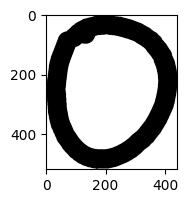

In [132]:
plt.figure(figsize=(5, 2))
plt.imshow(letter_image, cmap='gray')
plt.show()

In [21]:
# Create a binary threshold to ensure pure black and white
_, letter_image = cv2.threshold(letter_image, 127, 255, cv2.THRESH_BINARY_INV)

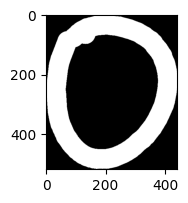

In [22]:
plt.figure(figsize=(5, 2))
plt.imshow(letter_image, cmap='gray')
plt.show()

In [23]:
kernel = np.ones((3, 3), np.uint8) 

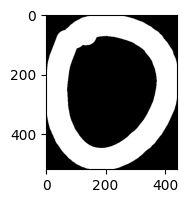

In [24]:
plt.figure(figsize=(5, 2))
plt.imshow(cv2.dilate(letter_image, kernel=kernel, iterations=4), cmap='gray')
plt.show()

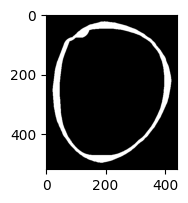

In [25]:
plt.figure(figsize=(5, 2))
plt.imshow(cv2.erode(letter_image, kernel=kernel, iterations=20), cmap='gray')
plt.show()

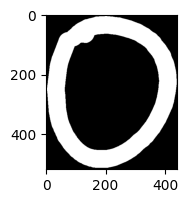

In [26]:
plt.figure(figsize=(5, 2))
plt.imshow(cv2.erode(letter_image, kernel=kernel, iterations=3), cmap='gray')
plt.show()

In [70]:
eroded_letter = cv2.erode(letter_image, kernel=kernel, iterations=20)

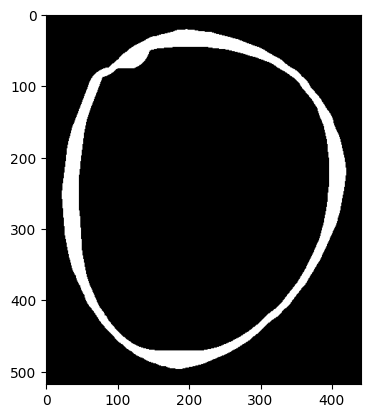

In [71]:
plt.imshow(eroded_letter, cmap="gray")

In [73]:
eroded_letter = cv2.bitwise_not(eroded_letter)

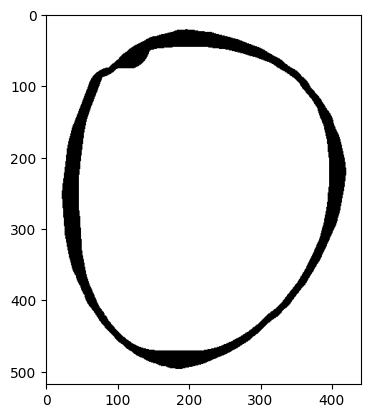

In [74]:
plt.imshow(eroded_letter, cmap="gray")

In [161]:
def apply_gaussian_grayscale(img, mean=128, std_dev=30):
    """
    Apply a Gaussian distribution to letter grayscale intensity on a white background.
    
    Parameters:
    - img: image to apply the Gaussian distribution to
    - mean: Center of the Gaussian distribution (default 128 - middle gray)
    - std_dev: Standard deviation of the Gaussian distribution
    
    Returns:
    - Original binary image
    - Gaussian-distributed grayscale image
    """
    alpha = None
    
    # handle alpha channel
    if img.shape[2] == 4:
        alpha = img[:, :, 3]
        img = img[:, :, :3]
        
    # Create a binary threshold to ensure white background, black letter
    _, binary_img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    
    # Create a mask for the letter (zero pixels)
    letter_mask = binary_img == 0
    
    # Create white background image
    gaussian_img = np.full_like(img, 255, dtype=np.float32)
    
    # Apply Gaussian distribution to letter pixels
    if np.any(letter_mask):
        # Generate Gaussian noise
        gaussian_noise = np.random.normal(
            loc=mean, 
            scale=std_dev, 
            size=img.shape
        )
        
        # Apply the noise only to letter pixels
        gaussian_img[letter_mask] = gaussian_noise[letter_mask]
        
        # Clip values to valid grayscale range
        gaussian_img = np.clip(gaussian_img, 0, 255).astype(np.uint8)

    if alpha is not None:
        alpha = alpha.reshape((*alpha.shape, 1))
        gaussian_img = np.concatenate((gaussian_img, alpha), axis=2)
    
    return gaussian_img

In [30]:
from sample_generation.image_utils import preprocess_images_to_concat, overlay_image
import pandas as pd

In [31]:
def get_rand_string_image(rand_string):
    images_to_concat = []
    handwritten_dataset_base_path = "../data/handwritten_dataset"
    handwritten_dataset_processed_base_path = "../data/handwritten_dataset_processed"

    labels = pd.read_csv(f"{handwritten_dataset_base_path}/labels.csv")

    # select random images from handwritten dataset for each letter
    for character in rand_string:
        character_image_path = labels[labels["label"] == character].sample(n=1)["image"].iloc[0]
    
        character_image = cv2.imread(f"{handwritten_dataset_processed_base_path}/{character_image_path}", flags=cv2.IMREAD_UNCHANGED)
        images_to_concat.append(character_image)

    images_to_concat_processed = preprocess_images_to_concat(images_to_concat, processing="scaling")

    return cv2.hconcat(images_to_concat_processed)

In [53]:
rand_string_image = get_rand_string_image("NATALIA")

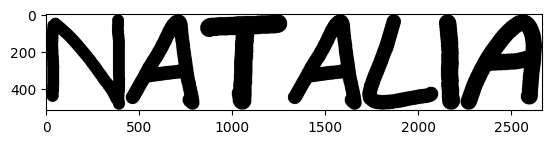

In [54]:
plt.imshow(rand_string_image)

In [38]:
rand_string_image.shape

(559, 5702, 4)

In [162]:
gaussian_img = apply_gaussian_grayscale(rand_string_image, mean=100, std_dev=20)

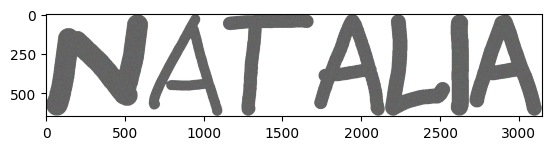

In [163]:
plt.imshow(gaussian_img, cmap="gray")

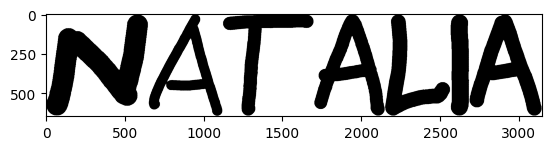

In [164]:
plt.imshow(np.where(gaussian_img == 255, 255, 0), cmap="gray")

In [173]:
overlayed_img = overlay_image(background=np.full_like(gaussian_img, 255)[:, :, :3], overlay=gaussian_img, position=(0, 0))

In [174]:
overlayed_img.shape

(646, 3147, 3)

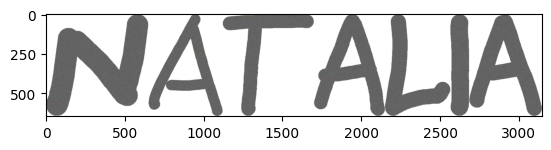

In [175]:
plt.imshow(overlayed_img, cmap="gray")

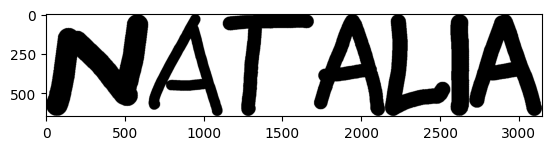

In [176]:
plt.imshow(np.where(overlayed_img == 255, 255, 0), cmap="gray")

In [115]:
def erode_letter_image(img: np.array, kernel_size: int = 3, iterations: int = 1):
    """
    Apply erosion to an image and invert colors.
    
    Parameters:
    - img: input image
    - kernel_size: Size of the erosion kernel (default is 3x3)
    
    Returns:
    - Original image
    - Eroded image
    - Inverted eroded image
    """    
    # Create a binary threshold to ensure pure black and white
    # Note the THRESH_BINARY_INV to make letter white, background black
    _, binary_img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)
    
    # Create a rectangular erosion kernel
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    
    # Apply erosion
    eroded_img = cv2.erode(binary_img, kernel, iterations=iterations)
    
    # Invert the eroded image (now white background, black letter)
    inverted_eroded_img = cv2.bitwise_not(eroded_img)

    # Apply alpha channel to the eroded part
    if img.shape[2] == 4:
        white_area = np.all(inverted_eroded_img[:, :, :3] == [255, 255, 255], axis=-1)
        inverted_eroded_img[white_area, -1] = 0
    
    return inverted_eroded_img

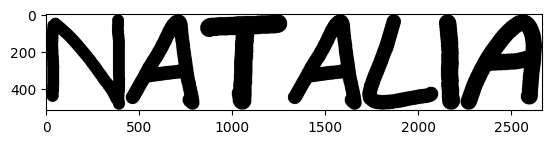

In [110]:
plt.imshow(rand_string_image, cmap="gray")

In [111]:
eroded_image = erode_letter_image(rand_string_image, iterations=10)

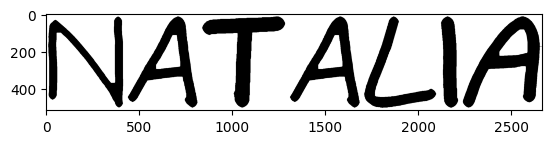

In [112]:
plt.imshow(eroded_image, cmap="gray")

In [113]:
overlayed_img = overlay_image(background=np.full_like(eroded_image, 200)[:, :, :3], overlay=eroded_image, position=(0, 0))

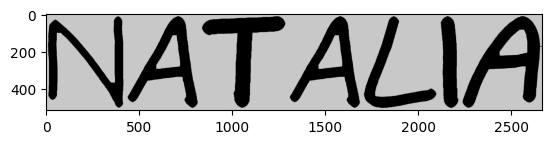

In [114]:
plt.imshow(overlayed_img, cmap="gray")

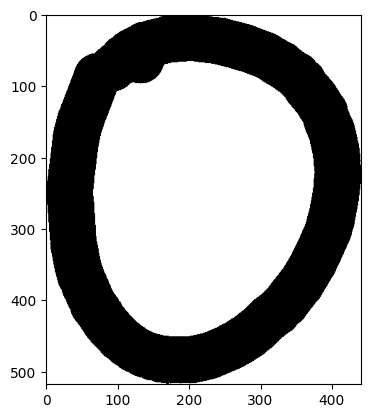

In [133]:
plt.imshow(letter_image, cmap="gray")

In [134]:
letter_image.shape

(518, 442, 4)

In [137]:
letter_image[0][0]

array([255, 255, 255,   0], dtype=uint8)

In [163]:
letter_image.shape

(518, 442, 4)

In [164]:
pad = np.full((letter_image.shape[0], 100, 4), np.array([255, 255, 255,   0]), dtype=np.uint8)

In [165]:
pad.shape

(518, 100, 4)

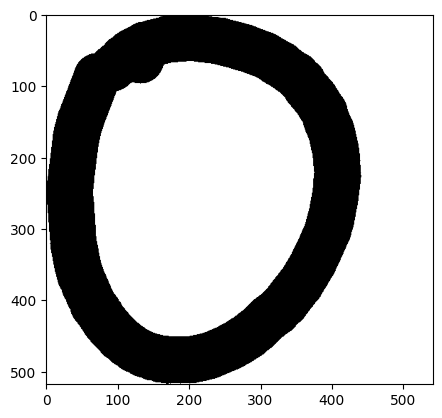

In [171]:
plt.imshow(cv2.hconcat([letter_image, pad]))

In [153]:
letter_image.dtype

dtype('uint8')

In [157]:
pad.dtype

dtype('int64')